<a href="https://colab.research.google.com/github/melihkurtaran/MachineLearning/blob/main/Supervised_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Supervised Learning Project**

My Case is E (I have completed all the tasks)

In this project, a dataset which has been collected using readings of a multi-spectral imaging sensor installed in a drone intended
to map a specific geographical area will be used for developing supervised machine learning models

In [220]:
#Load libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import tree
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std
from scipy.stats import sem
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import random
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score

In [221]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/MachineLearning.git

fatal: destination path 'MachineLearning' already exists and is not an empty directory.


In [222]:
# CSV to DataFrame 
ds_09 = pd.read_csv("MachineLearning/SupervisedLearning/ds_09.csv")
ds_09.head()

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,...,V29,V30,V31,V32,V33,V34,V35,V36,class,target
0,14.65,NaN,46.46,15.74,49.84,17.95,21.59,60.14,2.85,8.99,...,59.10,13.22,0.00,11.56,3.70,17.89,13.76,15.75,4,0.5272
1,13.97,NaN,19.38,5.99,21.44,31.61,45.76,26.47,2.52,26.66,...,32.93,12.02,14.30,17.82,3.15,11.77,14.46,16.38,1,0.4937
2,12.14,53.27,62.25,11.42,28.51,33.03,42.41,52.27,4.68,25.59,...,25.71,12.50,23.18,14.60,4.08,5.87,6.52,14.25,2,0.5796
3,8.29,16.06,15.41,6.97,14.81,16.53,29.76,36.73,3.14,20.58,...,31.74,9.67,8.43,21.87,6.03,10.20,12.54,7.82,5,0.4098
4,10.02,47.28,45.67,10.43,13.07,NaN,35.22,19.96,3.34,35.50,...,NaN,12.20,18.88,23.72,3.16,15.35,8.81,14.93,1,0.5465


There are 36 features and 2 values to be used in classification and regression tasks

# **T1 - Dataset preparation**

The dataset needs to be preprocessed before using in models

##**(a) removing missing values and outliers**

Samples have 38 rows, class and target row are never missing so thresh needs to setas 34 to drop samples with more than 4 missing feature values.

In [223]:
# samples with more than 4 missing feature values are dropped
print("Size before dropping: " + str(len(ds_09)))
ds_09 = ds_09.dropna(axis=0, thresh=34) # thresh: Require that many non-NA values
print("Size after dropping: " + str(len(ds_09)))

Size before dropping: 1000
Size after dropping: 967


Filling remaining null values with the mean

In [224]:
# the remaining missing values are filled using the average value

for i in ds_09.columns[ds_09.isnull().any(axis=0)]:  #Applying only on variables with NaN valuesfor bettter performance
    ds_09[i].fillna(ds_09[i].mean(),inplace=True)

In [225]:
# We can see that we do not have any missing values anymore
ds_09.isnull().values.any()

False

Removing outliers

In [226]:
# samples with at least one feature value with a z-score higher than 3 (i.e. an outlier) are discarded
print("Size before removing outlier samples: " + str(len(ds_09)))
# code below for each column, first calculates Z-score of each value in the column, and remove all rows that have outliers in at least one column
ds_09 = ds_09[(np.abs(stats.zscore(ds_09)) < 3).all(axis=1)] # axis=1 ensures that for each row, all column satisfy the constraint.
print("Size after removing outlier samples: " + str(len(ds_09)))

Size before removing outlier samples: 967
Size after removing outlier samples: 869


##**(b) Dimensionality Reduction**

Creating X and y from the dataset

In [227]:
X = ds_09.copy()
X.drop(['class', 'target'], axis=1, inplace=True)
y = ds_09['class']

Keep only features that account for up to 95% of the variance of the data

In [228]:
def find_optimal_num_components(df, threshold):
    """
    Find the minimum number of components needed to achieve a given explained variance ratio in a PCA of the given dataframe.
    
    Parameters:
        df (pandas.DataFrame): The data to perform PCA on.
        threshold (float): The minimum explained variance ratio to achieve.
        
    Returns:
        int: The minimum number of components needed to achieve the given explained variance ratio.
    """
    for i in range(1, len(df.columns) + 1):
        pca = PCA(n_components=i)
        principal_components = pca.fit_transform(df)
        variance = sum(pca.explained_variance_ratio_)
        if variance >= threshold:
            return i
    print("Unable to perform for the given variance.")
    return 0

# Find the minimum number of components needed to achieve 95% explained variance
num_components = find_optimal_num_components(X, 0.95)
print(f"Number of components needed for 95% explained variance: {num_components}")

# Perform PCA with the optimal number of components
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(X)

# Print the explained variance ratio and the transformed data
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")
X = pd.DataFrame(data=principal_components, columns=[f"pc {i+1}" for i in range(num_components)])
X.head(5)

Number of components needed for 95% explained variance: 15
Explained variance ratio: 0.9567635117802035


,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10,pc 11,pc 12,pc 13,pc 14,pc 15
0,46.321789,1.886644,-11.322145,-7.311741,20.715475,-4.950527,0.706346,6.953267,3.537840,9.784506,4.255089,-1.070923,-1.632111,1.950329,-3.063740
1,-12.328915,-6.429494,11.169730,8.098719,-10.904679,-4.729757,-3.827942,8.946575,4.939293,9.259626,-3.532233,2.507357,-1.524125,-0.303085,1.223547
2,3.240360,37.055949,-11.372926,0.959288,11.682581,16.377551,4.037160,4.419556,-3.821681,-0.497652,-1.348712,1.273029,-3.062338,-3.680973,3.855502
3,16.327169,-13.971399,31.503065,7.189114,-21.133782,2.890429,-15.936597,5.844498,-2.188759,-0.984916,-0.761827,5.412638,-0.948662,2.652619,0.163914
4,-11.439719,15.433202,19.498964,-21.176775,-2.428384,-3.020236,14.807770,-6.290017,-1.741523,-4.843511,0.703888,-0.292440,0.255032,-2.396215,0.759542


##**(c) Standardization**

mu-sigma standardization is used to normalize the features

In [229]:
# define mu-sigma standardizer scaler
ss = StandardScaler()
  
# transform data
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
X.head()

,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10,pc 11,pc 12,pc 13,pc 14,pc 15
0,2.284703,0.133656,-0.906135,-0.626408,2.207494,-0.577474,0.094651,1.137382,0.699196,1.991889,0.961907,-0.253459,-0.435886,0.528561,-0.959740
1,-0.608092,-0.455487,0.893937,0.693830,-1.162031,-0.551721,-0.512949,1.463438,0.976171,1.885036,-0.798498,0.593425,-0.407046,-0.082139,0.383285
2,0.159822,2.625165,-0.910199,0.082184,1.244926,1.910424,0.540985,0.722930,-0.755293,-0.101310,-0.304890,0.301292,-0.817855,-0.997584,1.207765
3,0.805296,-0.989780,2.521257,0.615902,-2.252070,0.337166,-2.135525,0.956015,-0.432572,-0.200505,-0.172219,1.281028,-0.253358,0.718889,0.051347
4,-0.564235,1.093339,1.560543,-1.814247,-0.258775,-0.352307,1.984261,-1.028891,-0.344184,-0.986022,0.159121,-0.069213,0.068111,-0.649401,0.237932


##**(d) Calculate IR**

The Imbalance Ratio (IR) is the ratio between the number of samples from the majority class and the number of samples from the minority class

In [230]:
ds_09['class'].value_counts() #Observe majority and minority class

1    230
4    224
5    148
0    132
3     68
2     67
Name: class, dtype: int64

In [231]:
IR = ds_09['class'].value_counts().max() / ds_09['class'].value_counts().min()
print('Imbalance Ratio: ' + str(IR))

Imbalance Ratio: 3.4328358208955225


# **T2 - Classifier design (I)**

4 different classifiers are defined in this task

## **(a) Find the best configuration for each model**

Best parameters found by GridSearchCV

Since the data imbalanced, it is better to use F1 score not the accuracy so all optimization is done based on weighted F1 score

### **1) Gaussian Naive Bayes (GNB)**

In [232]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()

### **2) Logistic Regression (LR)**

In [233]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(solver='saga', max_iter=5000, tol=0.001)
param_lr = [{'penalty': ['l1','l2','none'],'C': [0.1, 1, 10]}]

gs_lr = GridSearchCV(model_lr,
                      param_grid=param_lr,
                      scoring='f1_weighted',
                      cv=5)
gs_lr.fit(X, y)
gs_lr.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the

{'C': 0.1, 'penalty': 'l2'}

Best C value is 0.1 and best penalty value is l2.

In [234]:
model_lr = LogisticRegression(solver='saga', max_iter=5000, tol=0.001, C=0.1, penalty='l2')

### **3) Decision Tree (DT)**

In [235]:
model_dt = tree.DecisionTreeClassifier()
param_dt = [{'criterion': ['gini','entropy'],'max_depth': [3, 5, None],'min_samples_leaf': [1, 5, 10]}]

gs_dt = GridSearchCV(model_dt,
                      param_grid=param_dt,
                      scoring='f1_weighted',
                      cv=5)
gs_dt.fit(X, y)
gs_dt.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}

Best criterion value is entropy, better to set max_dept default which is None and best min. sample leaf is 1.

In [236]:
model_dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1)

### **4) Support Vector Machine (SVM)**

In [237]:
from sklearn import svm
model_svm = svm.SVC(gamma='scale', probability=True, max_iter=5000, tol=0.05)
param_svm = [{'kernel': ['linear','poly','rbf'],'C': [0.1, 1, 10]}]

gs_svm = GridSearchCV(model_svm,
                      param_grid=param_svm,
                      scoring='f1_weighted',
                      cv=5)
gs_svm.fit(X, y)
gs_svm.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-

{'C': 10, 'kernel': 'rbf'}

Best C value is 10 and the best kernel value is rbf

In [238]:
model_svm = svm.SVC(gamma='scale', probability=True, max_iter=5000, tol=0.05, C=10, kernel='rbf')

## **b) Estimate the accuracy, precision, recall and F1 scores**

In [239]:
# specifying the evaluation metrics
scoring = {'acc': 'accuracy',
           'pre': make_scorer(precision_score, average='weighted'),
           'rec': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted')}

# creating the cross-validation using 3-repetition, 5-fold 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# creating a dictionary to store the mean scores for each model
scores_mean = {}

models = [model_gnb,model_lr,model_dt,model_svm]
modelNames = ['GNB','LR','DT','SVM']
i = 0

for m in models: # for each classifiers
  # evaluate the classifier using 3-repetition, 5-fold cross-validation
  scores = cross_validate(m, X, y, scoring=scoring, cv=cv, n_jobs=-1)

  print('MODEL: ' + modelNames[i]) #printing what the model is
  i += 1
  # store the mean scores for each evaluation metric in the scores_mean dictionary
  scores_mean[str(m)] = {}
  for metric in scoring:
    mean = np.mean(scores['test_' + metric])
    scores_mean[str(m)][metric] = mean
    std = np.std(scores['test_' + metric])
    print(f'{metric}: {mean:.4f} (+/- {std * 2:.4f})')
  print()
 


MODEL: GNB
acc: 0.5884 (+/- 0.0384)
pre: 0.6132 (+/- 0.0613)
rec: 0.5884 (+/- 0.0384)
f1: 0.5879 (+/- 0.0444)

MODEL: LR
acc: 0.5631 (+/- 0.0584)
pre: 0.5867 (+/- 0.0515)
rec: 0.5631 (+/- 0.0584)
f1: 0.5601 (+/- 0.0580)

MODEL: DT
acc: 0.5443 (+/- 0.0560)
pre: 0.5483 (+/- 0.0527)
rec: 0.5443 (+/- 0.0560)
f1: 0.5431 (+/- 0.0541)

MODEL: SVM
acc: 0.7292 (+/- 0.0816)
pre: 0.7375 (+/- 0.0779)
rec: 0.7292 (+/- 0.0816)
f1: 0.7293 (+/- 0.0812)



## **c) Rank the models**

In imbalanced datasets, where the minority class is under-represented, it is important to choose an appropriate evaluation metric. The F1 score is a commonly used metric in imbalanced datasets, as it is a balanced measure of precision and recall and takes into account both the true positive and false positive rates. Therefore, four models ranked based on F1 Scores

Ranking

1.   Suppport Vector Machine with F1 score around **0.73**
2.   Gaussian Naive Bayes with F1 score around **0.59**
3.   Logistic Regression with F1 score around **0.56**
4.   Decision Tree with F1 score around **0.54**





Here, also the comparative barchart for each score metrics

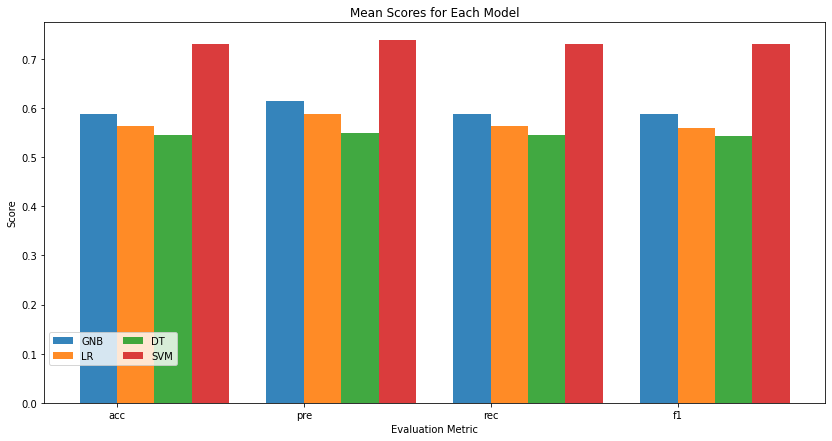

In [240]:
# create a bar plot of the mean scores for each model
fig, ax = plt.subplots(figsize=(14,7))
index = np.arange(len(scoring))
bar_width = 0.2
opacity = 0.9

for i, model in enumerate(scores_mean.keys()):
  ax.bar(index + i * bar_width, scores_mean[model].values(), bar_width, alpha=opacity, label=model)

ax.set_xlabel('Evaluation Metric')
ax.set_ylabel('Score')
ax.set_title('Mean Scores for Each Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(scoring.keys())
modelNames = ['GNB','LR','DT','SVM']

# move the legend to the bottom of the plot
ax.legend(modelNames,bbox_to_anchor=(0,0.2), prop={'size': 10}, loc='upper left', ncol=2)
plt.show()


Observing only F1 values

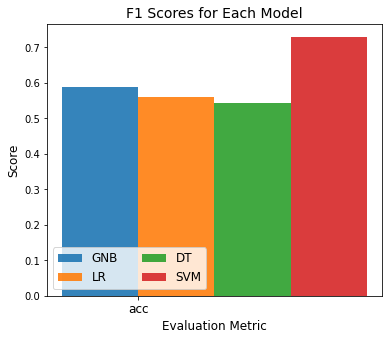

In [241]:
fig, ax = plt.subplots(figsize=(6,5))
index = np.arange(1) #since only f1 used

for i, model in enumerate(scores_mean.keys()):
  ax.bar(index + i * bar_width, scores_mean[model]['f1'], bar_width, alpha=opacity, label=model)

ax.set_xlabel('Evaluation Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('F1 Scores for Each Model', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(scoring.keys(), fontsize=12)
modelNames = ['GNB','LR','DT','SVM']

# move the legend to the bottom of the plot
ax.legend(modelNames,bbox_to_anchor=(0,0.2), prop={'size': 12}, loc='upper left', ncol=2)
plt.show()


It is clearly seen that SVM performs much better than all of the other models

# **T3 - Classifier design (II)**

## **(a) Ensemble Learning**

4 Ensemble Learning approaches developed: hard and soft voting, stacking and random forest.

### **1, 2) hard and soft voting**

In [242]:
# Hard voting:
model_hard = VotingClassifier(estimators=[('gnb', model_gnb), ('lr', model_lr), ('dt', model_dt), ('svm', model_svm)], voting='hard')

# Soft voting:
model_soft = VotingClassifier(estimators=[('gnb', model_gnb), ('lr', model_lr), ('dt', model_dt), ('svm', model_svm)], voting='soft')

### **3) Stacking**

In [243]:
# Creating the stacking classifier
model_stacking = StackingClassifier(estimators=[('gnb', model_gnb), ('lr', model_lr), ('dt', model_dt)], final_estimator=model_svm)

### **4) Random Forest (RF)**

In [244]:
model_rf = RandomForestClassifier()
param_rf = [{'n_estimators': [100, 200, 500],'min_samples_leaf': [5, 10],'criterion': ['gini','entropy']}]

gs_rf = GridSearchCV(model_rf,
                      param_grid=param_rf,
                      scoring='f1_weighted',
                      cv=5)
gs_rf.fit(X, y)
gs_rf.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 500}

Best criterion value is entropy, better to set min_samples_leaf to 5 and the best value for the number of tree is 200.

In [245]:
model_rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=5, n_estimators=200)

## **b) Estimate the accuracy, precision, recall and F1 scores**

In [246]:
# specifying the evaluation metrics
scoring = {'acc': 'accuracy',
           'pre': make_scorer(precision_score, average='weighted'),
           'rec': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted')}

# creating the cross-validation using 3-repetition, 5-fold 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# creating a dictionary to store the mean scores for each model
scores_mean_ensemble = {}

models = [model_hard,model_soft,model_stacking,model_rf]
modelNames = ['Hard Voting','Soft Voting','Stacking','Random Forest']
i = 0

for m in models: # for each classifiers
  # evaluate the classifier using 3-repetition, 5-fold cross-validation
  scores = cross_validate(m, X, y, scoring=scoring, cv=cv, n_jobs=-1)

  print('MODEL: ' + modelNames[i]) #printing what the model is
  i += 1

  # store the mean scores for each evaluation metric in the scores_mean_ensemble dictionary
  scores_mean_ensemble[str(m)] = {}
  for metric in scoring:
    mean = np.mean(scores['test_' + metric])
    scores_mean_ensemble[str(m)][metric] = mean
    std = np.std(scores['test_' + metric])
    print(f'{metric}: {mean:.4f} (+/- {std * 2:.4f})')
  print()
 


MODEL: Hard Voting
acc: 0.6559 (+/- 0.0642)
pre: 0.6835 (+/- 0.0593)
rec: 0.6559 (+/- 0.0642)
f1: 0.6565 (+/- 0.0631)

MODEL: Soft Voting
acc: 0.6698 (+/- 0.0564)
pre: 0.6822 (+/- 0.0510)
rec: 0.6698 (+/- 0.0564)
f1: 0.6678 (+/- 0.0563)

MODEL: Stacking
acc: 0.6206 (+/- 0.0867)
pre: 0.6349 (+/- 0.1018)
rec: 0.6206 (+/- 0.0867)
f1: 0.6169 (+/- 0.0922)

MODEL: Random Forest
acc: 0.6885 (+/- 0.0500)
pre: 0.7296 (+/- 0.0474)
rec: 0.6885 (+/- 0.0500)
f1: 0.6819 (+/- 0.0503)



## **c) Rank the eight models**

In imbalanced datasets, where the minority class is under-represented, it is important to choose an appropriate evaluation metric. The F1 score is a commonly used metric in imbalanced datasets, as it is a balanced measure of precision and recall and takes into account both the true positive and false positive rates. Therefore, all eight models ranked based on F1 Scores

Ranking

1.   Suppport Vector Machine with F1 score around **0.73**
2.   Random Forest with F1 score around **0.68**
3.   Soft Voting with F1 score around **0.66**
4.   Hard Voting with F1 score around **0.65**
5.   Stacking with F1 score around **0.61**
6.   Gaussian Naive Bayes with F1 score around **0.59**
7.   Logistic Regression with F1 score around **0.56**
8.   Decision Tree with F1 score around **0.54**






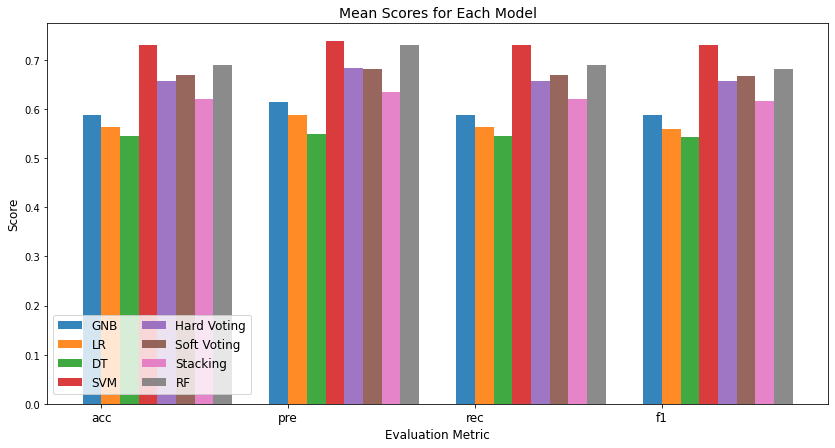

In [247]:
# adding to score values of ensemble methods results
scores_mean.update(scores_mean_ensemble)

# create a bar plot of the mean scores for each model
fig, ax = plt.subplots(figsize=(14,7))
index = np.arange(len(scoring))
bar_width = 0.1
opacity = 0.9

for i, model in enumerate(scores_mean.keys()):
  ax.bar(index + i * bar_width, scores_mean[model].values(), bar_width, alpha=opacity, label=model)

ax.set_xlabel('Evaluation Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Mean Scores for Each Model', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(scoring.keys(), fontsize=12)
model_names = ['GNB','LR','DT','SVM','Hard Voting','Soft Voting','Stacking','RF']

# move the legend to the bottom of the plot
ax.legend(model_names,bbox_to_anchor=(0,0.25), prop={'size': 12}, loc='upper left', ncol=2)
plt.show()

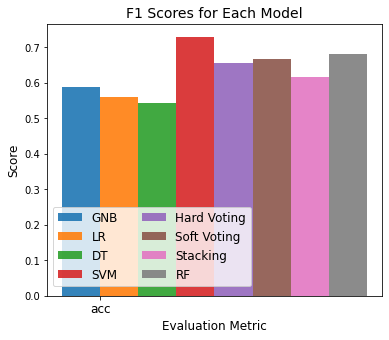

In [261]:
fig, ax = plt.subplots(figsize=(6,5))
index = np.arange(1) #since only f1 used
for i, model in enumerate(scores_mean.keys()):
  ax.bar(index + i * bar_width, scores_mean[model]['f1'], bar_width, alpha=opacity, label=model)
ax.set_xlabel('Evaluation Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('F1 Scores for Each Model', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(scoring.keys(), fontsize=12)
model_names = ['GNB','LR','DT','SVM','Hard Voting','Soft Voting','Stacking','RF']
# move the legend to the bottom of the plot
ax.legend(model_names,bbox_to_anchor=(0,0.35), prop={'size': 12}, loc='upper left', ncol=2)
plt.show()

Observing only F1 values

# **T4 - Regression**

Create X and y

In [249]:
X_reg = ds_09.drop(columns=['class', 'target'])
y_reg = ds_09['target']

standardize the data

In [250]:
# define mu-sigma standardizer scaler
ss = StandardScaler()
  
# transform data
X_reg = pd.DataFrame(ss.fit_transform(X_reg),columns = X_reg.columns)
X_reg.head()

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,...,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36
0,1.214996,-0.054054,1.152872,2.357207,2.216477,-1.496285,-1.158382,2.376606,-0.895622,-2.346782,...,-0.316122,-1.539320,2.279143,0.406997,-3.207810,-0.729132,0.408947,0.383839,1.212194,-0.099109
1,0.986969,-0.054054,-1.939001,-1.175792,-0.726378,-0.047792,1.256262,-0.882371,-1.204081,-0.161146,...,-1.312862,0.261232,-0.129392,0.010242,-0.254762,0.577851,-0.075171,-0.882510,1.432997,0.053858
2,0.373306,0.726206,2.955703,0.791817,0.006227,0.102783,0.921588,1.614855,0.814919,-0.293497,...,1.431467,-1.003106,-0.793879,0.168944,1.579018,-0.094431,0.743429,-2.103338,-1.071547,-0.463317
3,-0.917733,-2.285514,-2.392278,-0.820680,-1.413390,-1.646860,-0.342179,0.110712,-0.624553,-0.913193,...,-1.802451,-0.385048,-0.238912,-0.766735,-1.466957,1.423423,2.459851,-1.207375,0.827364,-2.024555
4,-0.337604,0.241384,1.062673,0.433082,-1.593692,-0.044691,0.203289,-1.512486,-0.437608,0.932290,...,1.481963,-0.760398,0.015906,0.069755,0.691039,1.809672,-0.066369,-0.141737,-0.349203,-0.298209


##**(a) Fit a multivariate linear regression model**

exclusively a first degree multivariate polynomial model is used

In [251]:
# Transform the features to include polynomial terms
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X_reg)

# create the model
model_r = LinearRegression()
# fit
model_r.fit(X_poly, y_reg)

LinearRegression()

##**(b) Estimate and report on the R2 measure and the root mean squared error**

In [252]:
# creating the cross-validation using 3-repetition, 5-fold 
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=3964)

# Evaluate the model using R2 measure
R2 = cross_val_score(model_r, X_poly, y_reg, scoring='r2', cv=cv, n_jobs=-1)

# Evaluate the model using root mean squared error
RMSE = cross_val_score(model_r, X_poly, y_reg, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
RMSE = abs(RMSE)

# Print the mean and standard deviation of the scores
print(f'R2 measure: {np.mean(R2):.4f} (+/- {np.std(R2) * 2:.4f})')
print(f'Root mean squared error: {np.mean(RMSE):.4f} (+/- {np.std(RMSE) * 2:.4f})')

R2 measure: 0.9699 (+/- 0.0087)
Root mean squared error: 0.0059 (+/- 0.0009)


R-squared (R2) is a common evaluation metric for regression models. It measures the proportion of the variance in the target variable that is explained by the model. An R2 value of 1 indicates that the model explains all the variance in the target variable, while an R2 value of 0 indicates that the model explains none of the variance. Since the mean R2 value is very close to 1, we can state the model is performing well.



 RMSE is more sensitive to the individual errors in the prediction. RMSE is a measure of the absolute error, while R2 is a measure of the squared error. Since the mean RMSE value is very low, the model has a good performance.

# **T5 - Model exploitation**

In [253]:
df_t5 = pd.read_csv('MachineLearning/SupervisedLearning/im_x_09.txt', sep=" ", header=None, index_col=False)
df_t5_y = pd.read_csv('MachineLearning/SupervisedLearning/im_y_09.txt', sep=" ", header=None, index_col=False)
df_t5_t = pd.read_csv('MachineLearning/SupervisedLearning/im_t_09.txt', sep=" ", header=None, index_col=False)
df_t5['class'] = df_t5_y
df_t5['target'] = df_t5_t

df_t5.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,class,target
0,10.56,53.90,28.49,9.56,35.65,38.17,45.36,22.96,3.43,27.41,...,27.15,15.54,18.56,19.07,2.82,14.04,14.95,19.99,0,0.557017
1,11.94,34.57,45.58,15.47,39.31,31.83,32.69,49.95,2.83,39.21,...,48.16,13.69,7.20,17.95,3.33,6.18,10.37,13.16,0,0.594420
2,6.29,45.65,31.93,11.38,39.51,36.15,29.35,37.18,5.32,20.21,...,32.70,16.90,16.10,12.59,2.09,11.36,14.21,17.10,0,0.519508
3,10.34,52.78,26.24,12.49,29.88,39.67,38.91,36.10,2.06,35.34,...,26.78,13.29,13.92,15.35,2.51,15.46,10.57,16.88,0,0.536709
4,8.25,53.67,30.91,3.57,18.04,27.73,28.09,19.02,3.41,31.42,...,34.27,12.07,15.83,23.11,2.11,18.25,6.78,9.40,0,0.510596


Creating X_exp and y_exp

In [254]:
X_exp = df_t5.copy()
X_exp.drop(['class', 'target'], axis=1, inplace=True)
y_exp = df_t5['class']

Dimensionality Reduction since training data have 15 features, the test data must have the same number of features

In [255]:
# Perform PCA with 15 number of components
pca = PCA(n_components=15)
principal_components = pca.fit_transform(X_exp)

# Print the explained variance ratio and the transformed data
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")
X_exp = pd.DataFrame(data=principal_components, columns=[f"pc {i+1}" for i in range(num_components)])
X_exp.head(5)

Explained variance ratio: 0.9712502430993828


,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10,pc 11,pc 12,pc 13,pc 14,pc 15
0,-20.629681,-7.948357,5.998480,-1.763332,8.867658,-8.939672,-1.282620,9.275053,-0.642283,1.985149,0.393067,1.279420,-5.594255,4.800435,-2.597315
1,38.142077,-2.862445,-5.146221,-4.469362,1.590061,-17.813532,6.020525,3.210381,-1.404566,-9.676070,0.152972,6.247040,-3.001085,2.736768,1.084261
2,-11.256948,11.370637,-7.059366,7.005518,7.720206,-2.143176,-8.036164,5.891335,0.315110,-3.903400,-3.676967,0.907786,-8.090470,2.092000,-2.979229
3,-14.712804,-9.614372,-5.910638,5.141970,-3.227029,-6.987868,-10.094717,0.972015,0.634060,-5.178892,2.264189,2.612988,-1.837532,-3.909555,-0.995834
4,-4.250027,-2.627471,9.164720,-25.199098,-6.477350,-4.514182,-0.223468,-4.081908,8.324834,11.630335,-1.339323,-1.771577,-5.990326,2.175292,2.745929


Standardization

In [256]:
# define mu-sigma standardizer scaler
ss = StandardScaler()
  
# transform data
X_exp = pd.DataFrame(ss.fit_transform(X_exp),columns = X_exp.columns)
X_exp.head()

,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10,pc 11,pc 12,pc 13,pc 14,pc 15
0,-0.850604,-0.474005,0.458412,-0.146639,0.927264,-1.045457,-0.167159,1.605605,-0.122937,0.413111,0.082953,0.294278,-1.382623,1.244474,-0.809797
1,1.572676,-0.170704,-0.393281,-0.371672,0.166268,-2.083218,0.784632,0.555749,-0.268843,-2.013597,0.032283,1.436874,-0.741720,0.709485,0.338053
2,-0.464147,0.678095,-0.539486,0.582579,0.807278,-0.250635,-1.047323,1.019849,0.060314,-0.812300,-0.775985,0.208799,-1.999564,0.542334,-0.928871
3,-0.606639,-0.573359,-0.451699,0.427606,-0.337441,-0.817202,-1.315606,0.168266,0.121363,-1.077731,0.477833,0.601010,-0.454147,-1.013521,-0.310483
4,-0.175237,-0.156691,0.700380,-2.095558,-0.677317,-0.527915,-0.029124,-0.706619,1.593428,2.420281,-0.282650,-0.407478,-1.480512,0.563927,0.856132


## **(a) Using the best classifier, classify each pixel**

The best model among all 8 classifiers is SVM so we test with SVM

In [257]:
#fitting the training data
model_svm.fit(X,y)

#predict
predictions = model_svm.predict(X_exp)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_exp, predictions)
print("Confusion matrix:")
print(confusion_mat)
print()
# Generate the classification report
report = classification_report(y_exp, predictions)
print(report)

Confusion matrix:
[[ 878 1014  160  258 1285  405]
 [ 238  815   70   53  189  135]
 [  58  301   34   82  295  130]
 [ 129  511   31  349  299  181]
 [  76  159  174   47  363   81]
 [ 120  364  178   70  116  352]]

              precision    recall  f1-score   support

           0       0.59      0.22      0.32      4000
           1       0.26      0.54      0.35      1500
           2       0.05      0.04      0.04       900
           3       0.41      0.23      0.30      1500
           4       0.14      0.40      0.21       900
           5       0.27      0.29      0.28      1200

    accuracy                           0.28     10000
   macro avg       0.29      0.29      0.25     10000
weighted avg       0.38      0.28      0.28     10000



The scores are not actually bad since we train the model with only 1,000 samples but we try to predict 10,000 samples.

F-score value of class-2 is pretty low, the reason can be explained by the training data. We only had 67 samples belong to class 2 which is the minimum number and we try to predict 900 values. The best result is belong to class-1 with 0.35 F-score and we had 230 samples (the max amount) for the training dataset for that class. For this reason, it seem that prediction of class-1 is more successful.

In [258]:
y.value_counts()

1    230
4    224
5    148
0    132
3     68
2     67
Name: class, dtype: int64

## **(b) Using the regressor, predict the target values**

In [259]:
X_exp = df_t5.copy()
X_exp.drop(['class', 'target'], axis=1, inplace=True)
y_exp = df_t5['target']

# define mu-sigma standardizer scaler
ss = StandardScaler()
  
# transform data
X_exp = pd.DataFrame(ss.fit_transform(X_exp),columns = X_exp.columns)

poly = PolynomialFeatures(degree=1)
X_exp_poly = poly.fit_transform(X_exp)

# Make predictions on the test data
predictions = model_r.predict(X_exp_poly)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_exp, predictions))

# Calculate the R2 score
r2 = r2_score(y_exp, predictions)

print("Root mean squared error:", rmse)
print("R2 score:", r2)

Root mean squared error: 0.00713076055408048
R2 score: 0.9597576073277467


Since the mean R2 value is very close to 1 and RMSE value is quite low, we can state the regressor model is performing very well.